In [ ]:
# for quantify the substrate

In [1]:
%cd ~/REVIVAL2
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

/disk2/fli/REVIVAL2


In [2]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

from REVIVAL.util import get_file_name

from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator, DataStructs

from REVIVAL.global_param import LIB_INFO_DICT

/disk2/fli/miniconda3/envs/SSMuLA_2/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [5]:
# loop all datasets to get spearmanr between esm_score and fitness
datasets = glob("/disk2/fli/REVIVAL2/zs/comb/Pf*.csv")

# Initialize a list to store results
results = []

# Define the columns and their transformations
columns = {
    "ed": (-1, "n_mut"),
    "ev": (1, "ev_score"),
    "esm": (1, "esm_score"),
    "esmif": (1, "esmif_score"),
    "coves": (1, "coves_score"),
    "Triad": (-1, "Triad_score"),
}

# Loop through each dataset and calculate Spearman correlations
for d in datasets:
    substrate = get_file_name(d).split("_")[-1].replace("PfTrpB-", "")
    df = pd.read_csv(d)
    
    # Calculate Spearman correlations using dictionary comprehension
    correlations = {name: spearmanr(multiplier * df[col], df["fitness"])[0] 
                    for name, (multiplier, col) in columns.items()}
    
    # Append the substrate and correlations to results
    correlations["substrate"] = substrate
    results.append(correlations)

# Convert list of dictionaries to DataFrame
zs_sum_df = pd.DataFrame(results, columns=["substrate"] + list(columns.keys()))

In [6]:
zs_sum_df

,substrate,ed,ev,esm,esmif,coves,Triad
0,5iodo,0.268085,0.419296,0.479928,0.465625,0.290500,0.416078
1,5bromo,0.331510,0.487423,0.523450,0.504707,0.337215,0.517580
2,5cyano,0.301809,0.396476,0.425708,0.446164,0.442473,0.455794
3,56chloro,0.318860,0.388337,0.461043,0.441686,0.328487,0.420706
4,6chloro,0.417893,0.569694,0.612678,0.599645,0.550435,0.640586
5,4cyano,0.234953,0.329215,0.352757,0.372780,0.314705,0.382401
6,4bromo,0.371285,0.474594,0.478416,0.523394,0.482361,0.507517
7,7iodo,0.369552,0.493195,0.548700,0.568536,0.321261,0.581679
8,7methyl,0.390165,0.498362,0.561501,0.530903,0.434068,0.590426
9,7bromo,0.324373,0.539337,0.610375,0.516013,0.561438,0.530824


In [21]:
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys
from rdkit.Chem import DataStructs
from rdkit.Chem.rdFMCS import FindMCS
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator, GetAtomPairGenerator

# Example SMILES strings
smiles_list = [
    "C12=C(C=CN2)C=CC=C1",  # indole
] + [v["substrate-smiles"] for k, v in LIB_INFO_DICT.items() if "PfTrpB-" in k]

name_list = ["indole"] + [v["substrate"] for k, v in LIB_INFO_DICT.items() if "PfTrpB-" in k]

# Convert SMILES to RDKit molecule objects
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

# Initialize fingerprint generators
morgan_gen = GetMorganGenerator(radius=20)  # Morgan (circular) fingerprint generator
atom_pair_gen = GetAtomPairGenerator()     # Atom-Pair fingerprint generator

# Function to compute Morgan Fingerprint
def compute_morgan_fingerprint(mol):
    return morgan_gen.GetFingerprint(mol)

# Function to compute MACCS keys
def compute_maccs_fingerprint(mol):
    return MACCSkeys.GenMACCSKeys(mol)

# Function to compute Atom-Pair Fingerprints
def compute_atom_pair_fingerprint(mol):
    return atom_pair_gen.GetFingerprint(mol)

# Compute fingerprints for each molecule
morgan_fps = [compute_morgan_fingerprint(mol) for mol in mols]
maccs_fps = [compute_maccs_fingerprint(mol) for mol in mols]
atom_pair_fps = [compute_atom_pair_fingerprint(mol) for mol in mols]

# Calculate pairwise similarity
num_molecules = len(morgan_fps)
morgan_matrix = [[0] * num_molecules for _ in range(num_molecules)]
maccs_matrix = [[0] * num_molecules for _ in range(num_molecules)]
atom_pair_matrix = [[0] * num_molecules for _ in range(num_molecules)]

# Compute similarity (Tanimoto) between molecules using Morgan fingerprints
for i in range(len(mols)):
    for j in range(i, len(mols)):
        morgan_matrix[i][j] = DataStructs.FingerprintSimilarity(morgan_fps[i], morgan_fps[j])
        morgan_matrix[j][i] = DataStructs.FingerprintSimilarity(morgan_fps[i], morgan_fps[j])

        maccs_matrix[i][j] = DataStructs.FingerprintSimilarity(maccs_fps[i], maccs_fps[j])
        maccs_matrix[j][i] = DataStructs.FingerprintSimilarity(maccs_fps[i], maccs_fps[j])

        atom_pair_matrix[i][j] = DataStructs.FingerprintSimilarity(atom_pair_fps[i], atom_pair_fps[j])
        atom_pair_matrix[j][i] = DataStructs.FingerprintSimilarity(atom_pair_fps[i], atom_pair_fps[j])

        # print(f"Morgan similarity between {smiles_list[i]} and {smiles_list[j]}: {similarity:.2f}")

# Compute Maximum Common Substructure (MCS)
# mcs = FindMCS(mols)
# mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
# mcs_smiles = Chem.MolToSmiles(mcs_mol)

# print(f"Maximum Common Substructure (MCS): {mcs_smiles}")


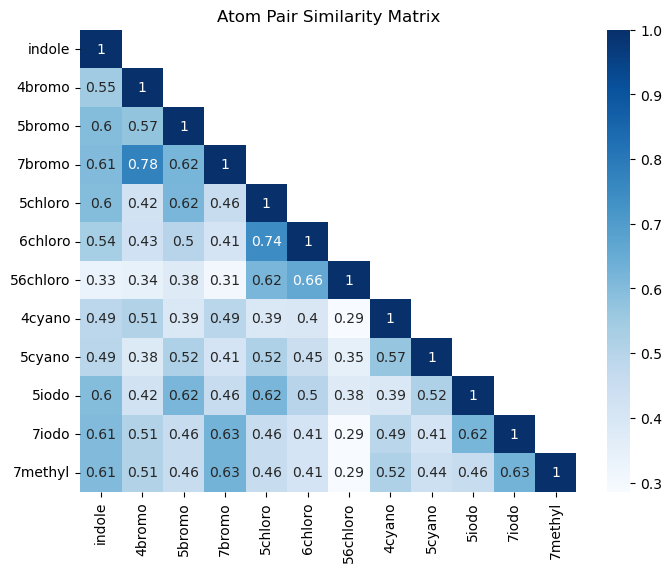

In [22]:
plt.figure(figsize=(8, 6))
mask = np.triu(np.ones_like(atom_pair_matrix, dtype=bool), k=1)
sns.heatmap(atom_pair_matrix, annot=True, mask=mask, cmap='Blues', xticklabels=name_list, yticklabels=name_list)
plt.title("Atom Pair Similarity Matrix")
plt.show()

In [25]:
sm_df = pd.DataFrame({"substrate": name_list, "morgan": morgan_matrix[0], "MACCS": maccs_matrix[0], "Atom Pair": atom_pair_matrix[0]})
# similarity_matrix[0]
sm_df

,substrate,morgan,MACCS,Atom Pair
0,indole,1.000000,1.000000,1.000000
1,4bromo,0.244444,0.777778,0.550000
2,5bromo,0.325581,0.777778,0.600000
3,7bromo,0.239130,0.777778,0.605263
4,5chloro,0.325581,0.777778,0.600000
5,6chloro,0.325581,0.777778,0.536585
6,56chloro,0.295455,0.700000,0.333333
7,4cyano,0.244898,0.875000,0.489362
8,5cyano,0.291667,0.875000,0.489796
9,5iodo,0.325581,0.777778,0.600000


In [26]:
merge_df = (
    pd.merge(zs_sum_df, sm_df, on="substrate", how="inner")
    .rename({"ed": "Hamming distance", "ev": "EVmutation", "esm": "ESM", "esmif": "ESM-IF", "coves": "CoVES", "Triad": "Triad"}, axis=1)
    .sort_values(["Atom Pair", "morgan"], ascending=False)
    .set_index("substrate")
)
merge_df

,Hamming distance,EVmutation,ESM,ESM-IF,CoVES,Triad,morgan,MACCS,Atom Pair
substrate,,,,,,,,,
7iodo,0.369552,0.493195,0.548700,0.568536,0.321261,0.581679,0.244444,0.777778,0.605263
7methyl,0.390165,0.498362,0.561501,0.530903,0.434068,0.590426,0.239130,0.933333,0.605263
7bromo,0.324373,0.539337,0.610375,0.516013,0.561438,0.530824,0.239130,0.777778,0.605263
5iodo,0.268085,0.419296,0.479928,0.465625,0.290500,0.416078,0.325581,0.777778,0.600000
5bromo,0.331510,0.487423,0.523450,0.504707,0.337215,0.517580,0.325581,0.777778,0.600000
5chloro,0.387294,0.521059,0.582487,0.551743,0.401971,0.531527,0.325581,0.777778,0.600000
4bromo,0.371285,0.474594,0.478416,0.523394,0.482361,0.507517,0.244444,0.777778,0.550000
6chloro,0.417893,0.569694,0.612678,0.599645,0.550435,0.640586,0.325581,0.777778,0.536585
5cyano,0.301809,0.396476,0.425708,0.446164,0.442473,0.455794,0.291667,0.875000,0.489796


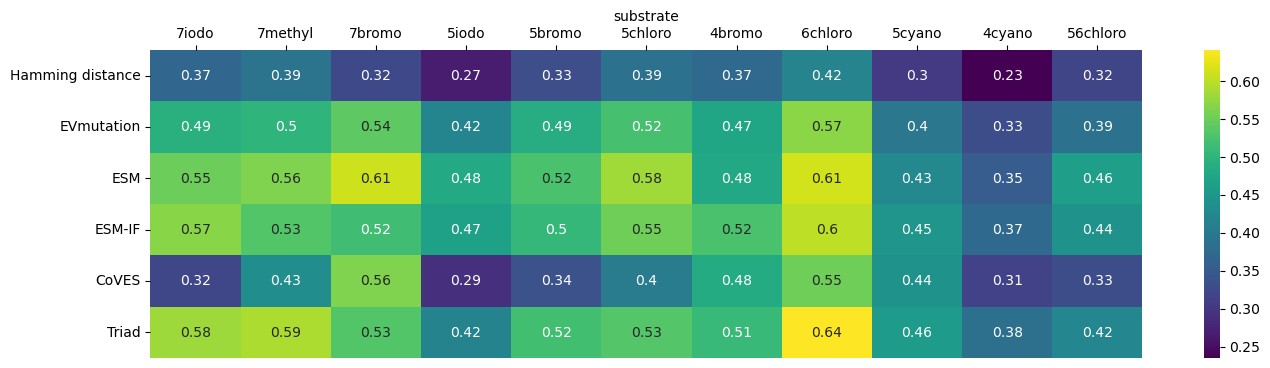

In [27]:
plt.figure(figsize=(16, 4))
ax = sns.heatmap(merge_df.iloc[:, :-3].T, cmap='viridis', annot=True)
# Move the x-axis ticks to the top
ax.xaxis.set_ticks_position('top')  # Moves the ticks to the top
ax.xaxis.set_label_position('top')  # Moves the labels to the top


In [28]:
ZS_OPTS = ["Hamming distance", "EVmutation", "ESM", "ESM-IF", "CoVES", "Triad"]

In [29]:
merge_df.iloc[:, :-3].mean()

Hamming distance    0.337798
EVmutation          0.465181
ESM                 0.512458
ESM-IF              0.501927
CoVES               0.405901
Triad               0.506829
dtype: float64

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu

def test_ptm4fit(fit: np.ndarray, ptm: np.ndarray, ptm_cutoff: float = 0.7):
    # Split the data based on the threshold ptm > 0.7
    fit_high_ptm = fit[ptm > ptm_cutoff]
    fit_low_ptm = fit[ptm <= ptm_cutoff]

    # Visualize the two groups
    plt.boxplot([fit_low_ptm, fit_high_ptm], labels=[f"ptm ≤ {ptm_cutoff}", f"ptm > {ptm_cutoff}"])
    plt.title("Fit Values for Different PTM Thresholds")
    plt.ylabel("Fit")
    plt.show()

    # Perform statistical tests
    # T-test (assumes normality of distributions)
    t_stat, p_val_ttest = ttest_ind(fit_low_ptm, fit_high_ptm, equal_var=False)

    # Mann-Whitney U test (non-parametric test)
    u_stat, p_val_mwu = mannwhitneyu(fit_low_ptm, fit_high_ptm, alternative='two-sided')

    # Print results
    print("T-test: t-statistic = {:.3f}, p-value = {:.3e}".format(t_stat, p_val_ttest))
    print("Mann-Whitney U test: U-statistic = {:.3f}, p-value = {:.3e}".format(u_stat, p_val_mwu))

    return t_stat, p_val_ttest, u_stat, p_val_mwu

In [31]:
# add row for mean and std for each column
slice_merge_df = merge_df[ZS_OPTS].copy()
slice_merge_df.loc["mean"] = slice_merge_df[ZS_OPTS].mean()
slice_merge_df.loc["std"] = slice_merge_df[ZS_OPTS].std()
slice_merge_df

,Hamming distance,EVmutation,ESM,ESM-IF,CoVES,Triad
substrate,,,,,,
7iodo,0.369552,0.493195,0.548700,0.568536,0.321261,0.581679
7methyl,0.390165,0.498362,0.561501,0.530903,0.434068,0.590426
7bromo,0.324373,0.539337,0.610375,0.516013,0.561438,0.530824
5iodo,0.268085,0.419296,0.479928,0.465625,0.290500,0.416078
5bromo,0.331510,0.487423,0.523450,0.504707,0.337215,0.517580
5chloro,0.387294,0.521059,0.582487,0.551743,0.401971,0.531527
4bromo,0.371285,0.474594,0.478416,0.523394,0.482361,0.507517
6chloro,0.417893,0.569694,0.612678,0.599645,0.550435,0.640586
5cyano,0.301809,0.396476,0.425708,0.446164,0.442473,0.455794


In [32]:
slice_merge_df.loc["mean"]

Hamming distance    0.337798
EVmutation          0.465181
ESM                 0.512458
ESM-IF              0.501927
CoVES               0.405901
Triad               0.506829
Name: mean, dtype: float64

Loading BokehJS ...

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
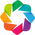

In [33]:
from REVIVAL.vis_param import FZL_PALETTES

In [34]:
%matplotlib inline

/tmp/ipykernel_4008959/4246899327.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ZS_OPTS, rotation=90, ha="center")


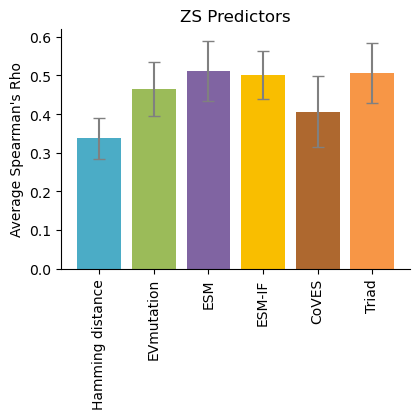

In [35]:
# Plotting
fig, ax = plt.subplots(figsize=(4, 4))

# Perform t-tests between each pair of ZS predictors within the metric
p_values = {}

means = slice_merge_df.loc["mean"]

bars = ax.bar(
    ZS_OPTS,
    means,
    yerr=slice_merge_df.loc["std"].to_list(),
    capsize=4,
    color=[
        FZL_PALETTES[c]
        for c in ["blue", "green", "purple", "yellow", "brown", "orange"]
    ],
    width=0.8,
    error_kw={'ecolor': 'gray', 'capthick': 1} 
    
)
# make the font size smaller

    # Annotating p-values
for i, (pair, p_value) in enumerate(p_values.items()):
    if p_value < 0.05:
        ax.text(i, max(means) + 10, "*", ha="center", color="gray")

# Set the title and labels
ax.set_title("ZS Predictors")
ax.set_xticklabels(ZS_OPTS, rotation=90, ha="center")
ax.set_ylabel("Average Spearman's Rho")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)  # Disable the y-axis grid lines

plt.tight_layout(pad=.0, h_pad=-.0, w_pad=1.0)

In [36]:
df_melted

NameError: name 'df_melted' is not defined

In [37]:
merge_df["Atom Pair"]

substrate
7iodo       0.605263
7methyl     0.605263
7bromo      0.605263
5iodo       0.600000
5bromo      0.600000
5chloro     0.600000
4bromo      0.550000
6chloro     0.536585
5cyano      0.489796
4cyano      0.489362
56chloro    0.333333
Name: Atom Pair, dtype: float64

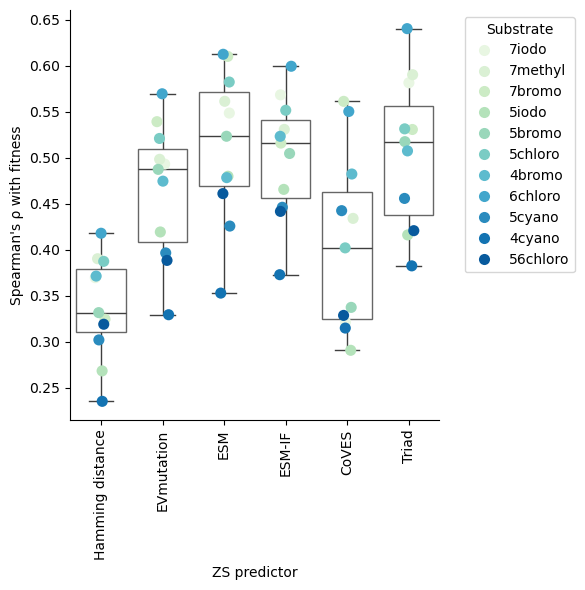

In [38]:
# Melt the dataframe to long format for seaborn boxplot and stripplot
df_melted = pd.melt(
    merge_df.iloc[:, :6].reset_index(),
    id_vars="substrate",
    var_name="ZS predictor",
    value_name="Spearman's ρ with fitness",
)


# Create the boxplot and stripplot
plt.figure(figsize=(6, 6))
ax = sns.boxplot(x="ZS predictor", y="Spearman's ρ with fitness", data=df_melted,
boxprops={
            "facecolor": "None",
            "edgecolor": FZL_PALETTES["gray"],
        },)
sns.stripplot(
    x="ZS predictor",
    y="Spearman's ρ with fitness",
    hue="substrate",
    data=df_melted,
    palette="GnBu",# glasbey_category10[:11],
    jitter=True,
    size=8,
    marker="o",
    ax=ax,
)

# Hide the top and right spine
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# rotate x-axis labels
plt.xticks(rotation=90)

# Adjust legend
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Substrate")

# Show the plot
plt.tight_layout()
plt.show()

In [40]:
merge_df

,Hamming distance,EVmutation,ESM,ESM-IF,CoVES,Triad,morgan,MACCS,Atom Pair
substrate,,,,,,,,,
7iodo,0.369552,0.493195,0.548700,0.568536,0.321261,0.581679,0.244444,0.777778,0.605263
7methyl,0.390165,0.498362,0.561501,0.530903,0.434068,0.590426,0.239130,0.933333,0.605263
7bromo,0.324373,0.539337,0.610375,0.516013,0.561438,0.530824,0.239130,0.777778,0.605263
5iodo,0.268085,0.419296,0.479928,0.465625,0.290500,0.416078,0.325581,0.777778,0.600000
5bromo,0.331510,0.487423,0.523450,0.504707,0.337215,0.517580,0.325581,0.777778,0.600000
5chloro,0.387294,0.521059,0.582487,0.551743,0.401971,0.531527,0.325581,0.777778,0.600000
4bromo,0.371285,0.474594,0.478416,0.523394,0.482361,0.507517,0.244444,0.777778,0.550000
6chloro,0.417893,0.569694,0.612678,0.599645,0.550435,0.640586,0.325581,0.777778,0.536585
5cyano,0.301809,0.396476,0.425708,0.446164,0.442473,0.455794,0.291667,0.875000,0.489796


/tmp/ipykernel_4008959/72951286.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ZS_OPTS, rotation=90, ha="center")


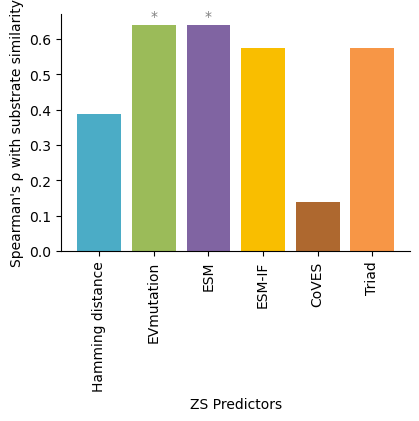

In [41]:
# Plotting
fig, ax = plt.subplots(figsize=(4, 4))

# Perform t-tests between each pair of ZS predictors within the metric
p_values = [spearmanr(merge_df["Atom Pair"], merge_df[zsopt])[1] for zsopt in ZS_OPTS]

bars = ax.bar(
    ZS_OPTS,
    [spearmanr(merge_df["Atom Pair"], merge_df[zsopt])[0] for zsopt in ZS_OPTS],
    capsize=4,
    color=[
        FZL_PALETTES[c]
        for c in ["blue", "green", "purple", "yellow", "brown", "orange"]
    ],
    width=0.8,
    error_kw={'ecolor': 'gray', 'capthick': 1} 
    
)
# make the font size smaller

    # Annotating p-values
for i, p_value in enumerate(p_values):
    if p_value < 0.05:
        ax.text(i, max(p_values)-0.03, "*", ha="center", color="gray")

# Set the title and labels
# ax.set_title("ZS Predictors", pad=10)
ax.set_xticklabels(ZS_OPTS, rotation=90, ha="center")
ax.set_xlabel("ZS Predictors")
ax.set_ylabel("Spearman's ρ with substrate similarity")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)  # Disable the y-axis grid lines

plt.tight_layout(pad=.0, h_pad=-.0, w_pad=1.0)